# Bytepairencoding seq2seq model in keras that translates english <-> german

As a next step I take the model used for the [toy problem of adding/subtracting numbers](SimpleModelForAddingAndSubstraction.ipynb) and train it with english/german data for machine translation.

As trainings set I use the [European Parliament Proceedings Parallel Corpus 1996-2011](http://statmt.org/europarl/) German-English corpus.

In [1]:
# technical detail so that an instance (maybe running in a different window)
# doesn't take all the GPU memory resulting in some strange error messages
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
set_session(tf.Session(config=config))

/home/janek/.local/share/virtualenvs/rosetta-WKmHhL03/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import math
import matplotlib.pyplot as plt
import os
import re
import tarfile

from gensim.models import KeyedVectors
import keras
import keras.layers as L
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
import numpy as np
import pandas as pd
import requests
import sentencepiece as spm
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook as tqdm

# Fixing random state ensure reproducible results
RANDOM_STATE=42
np.random.seed(RANDOM_STATE)
tf.set_random_seed(RANDOM_STATE)

In [3]:
START = '^'
END = '\n'

MAX_INPUT_LENGTH = 25 #50
MAX_TARGET_LENGTH = 35 #65
LATENT_DIM = 512
EMBEDDING_DIM = 100
BPE_MERGE_OPERATIONS = 1000
EPOCHS = 20
BATCH_SIZE = 128
DROPOUT = 0.5
TEST_SIZE=500

## Download and explore data

In [4]:
def download_file(fname, url):
    print(f"Downloading {fname} from {url} ...")
    response = requests.get(url, stream=True)

    total_size = int(response.headers.get('content-length', 0)); 
    block_size = 1024

    download = tqdm(
        response.iter_content(block_size),
        total=math.ceil(total_size // block_size),
        unit='KB',
        unit_scale=True
    )
    with open(f"{fname}", "wb") as handle:
        for data in download:
            handle.write(data)

PATH = 'data'
BPE_URL = 'http://cosyne.h-its.org/bpemb/data/en/'
BPE_INPUT_MODEL_NAME = f'en.wiki.bpe.op{BPE_MERGE_OPERATIONS}.model'
BPE_INPUT_WORD2VEC_NAME = f'en.wiki.bpe.op{BPE_MERGE_OPERATIONS}.d{EMBEDDING_DIM}.w2v.bin'
DOWNLOAD_FILES = {
    'de-en.tgz': 'http://statmt.org/europarl/v7/de-en.tgz',
    BPE_INPUT_MODEL_NAME: f'{BPE_URL}/{BPE_INPUT_MODEL_NAME}',
    BPE_INPUT_WORD2VEC_NAME + '.tar.gz': f'{BPE_URL}/{BPE_INPUT_WORD2VEC_NAME}' + '.tar.gz',
}
os.makedirs(PATH, exist_ok=True)

for name, url in DOWNLOAD_FILES.items():
    fname = os.path.join(PATH, name)
    exists = os.path.exists(fname)
    size = os.path.getsize(fname) if exists else -1
    if exists and size > 0:
        print(f'{name} already downloaded ({size / 2**20:3.1f} MB)')
        continue
    download_file(fname, url)
    if (re.search(r'\.(tgz|tar\.gz)$', fname)):
        tar = tarfile.open(fname, "r:gz")
        tar.extractall(path=PATH)
        tar.close()
        print(f'Extracted {fname} ...')


de-en.tgz already downloaded (188.6 MB)
en.wiki.bpe.op1000.model already downloaded (0.2 MB)
en.wiki.bpe.op1000.d100.w2v.bin.tar.gz already downloaded (0.7 MB)


In [5]:
# Following https://github.com/bheinzerling/bpemb/blob/master/preprocess_text.sh
# (ignoring urls as there shouldn't be any in parliament discussions)
def preprocess(line):
    line = re.sub(r'\d+', '0', line)
    line = re.sub(r'\s+', ' ', line)  # keep newlines, but strip together all other whitespaces
    return line.lower().strip()

def read_corpus_lines(language):
    return [preprocess(line) for line in open(f'{PATH}/europarl-v7.de-en.{language}', 'r').readlines()]
    
pd.set_option('max_colwidth', 60)
df = pd.DataFrame(data={
    'input_texts': read_corpus_lines('en'),
    'target_texts': read_corpus_lines('de'), 
})
df.target_texts = START + df.target_texts + END

In [6]:
len(df)
df.target_texts = df.target_texts  # encode a start symbol (doesn't occur in texts)
df['input_length'] = df.input_texts.apply(len)
df['target_length'] = df.target_texts.apply(len)
df.head()

1920209

,input_texts,target_texts,input_length,target_length
0,resumption of the session,^wiederaufnahme der sitzungsperiode\n,25,36
1,i declare resumed the session of the european parliament...,"^ich erkläre die am freitag, dem 0. dezember unterbroche...",203,219
2,"although, as you will have seen, the dreaded 'millennium...","^wie sie feststellen konnten, ist der gefürchtete ""mille...",191,187
3,you have requested a debate on this subject in the cours...,^im parlament besteht der wunsch nach einer aussprache i...,105,112
4,"in the meantime, i should like to observe a minute' s si...",^heute möchte ich sie bitten - das ist auch der wunsch e...,232,219


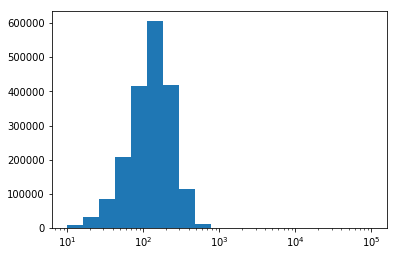

In [7]:
x = df.input_length
logbins = np.logspace(1,5,20)
plt.hist(x, bins=logbins)
plt.xscale('log')
plt.show();

In [8]:
non_empty = (df.input_length > 3) & (df.target_length > 3)  # there are empty phrases like '\n' --> 'Frau Präsidentin\n'
short_inputs = (df.input_length < MAX_INPUT_LENGTH) & (df.target_length < MAX_TARGET_LENGTH)
sum(short_inputs)
df = df[non_empty & short_inputs]

42656

In [9]:
input_pretrained_bpe = KeyedVectors.load_word2vec_format(os.path.join(PATH, BPE_INPUT_WORD2VEC_NAME), binary=True)
sp = spm.SentencePieceProcessor()
sp.Load(os.path.join(PATH, BPE_INPUT_MODEL_NAME))
subwords = sp.EncodeAsPieces("this is a test")
print(subwords)

True

['▁this', '▁is', '▁a', '▁t', 'est']


In [10]:
input_wordvec_index = dict({
    word: index 
    for index, word 
    in enumerate(['<pad>', '<s>', '</s>'] + input_pretrained_bpe.wv.index2word)  # haven't found start/stop tokens, so add them manually
})
input_unk_index = input_wordvec_index['<unk>']

def subword_indices(text, unk_index=input_unk_index, wordvec_index=input_wordvec_index):
    subwords = ['<s>'] + sp.EncodeAsPieces(text) + ['</s>']  # automatic add start/stop index
    return [wordvec_index.get(subword, unk_index) for subword in subwords]

FULL_EMBEDDING_DIM = EMBEDDING_DIM + 2
input_embedding_matrix = np.zeros((len(input_wordvec_index), FULL_EMBEDDING_DIM))
input_embedding_matrix[0, :] = 1e-6 * np.random.standard_normal(FULL_EMBEDDING_DIM)  # pad symbol as close to zero
input_embedding_matrix[1, -1] = 1  # one hot encode start symbol
input_embedding_matrix[2, -2] = 1  # one hot encode stop symbol
input_embedding_matrix[3:, :-2] = input_pretrained_bpe.wv.vectors

df['input_sequences'] = df.input_texts.apply(subword_indices)

/home/janek/.local/share/virtualenvs/rosetta-WKmHhL03/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  after removing the cwd from sys.path.
/home/janek/.local/share/virtualenvs/rosetta-WKmHhL03/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


In [11]:
input_embedding_matrix[:4, -8:]

array([[-3.92108153e-07, -1.46351495e-06,  2.96120277e-07,
         2.61055272e-07,  5.11345664e-09, -2.34587133e-07,
        -1.41537074e-06, -4.20645323e-07],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00],
       [-1.54319003e-01,  1.55878007e-01,  5.60858011e-01,
        -1.23772003e-01,  1.91783994e-01,  3.10420003e-02,
         0.00000000e+00,  0.00000000e+00]])

In [12]:
# corpus = pd.concat([df.input_texts, df.target_texts])
corpus = df.target_texts

In [13]:
tokenizer = keras.preprocessing.text.Tokenizer(num_words=100, filters=None, char_level=True, oov_token='~')
tokenizer.fit_on_texts(corpus)
# df['input_sequences'] = tokenizer.texts_to_sequences(df.input_texts)
df['target_sequences'] = tokenizer.texts_to_sequences(df.target_texts)

In [14]:
list(reversed(sorted(tokenizer.word_counts.items(), key=lambda d: d[1])))
sum(1 for w, count in tokenizer.word_counts.items() if count > 1000)

[('e', 76780),
 (' ', 71364),
 ('s', 58492),
 ('i', 52225),
 ('n', 42885),
 ('a', 41066),
 ('r', 33748),
 ('\n', 32815),
 ('^', 32815),
 ('t', 32215),
 ('h', 29135),
 ('l', 25430),
 ('d', 24860),
 ('c', 21765),
 ('u', 18556),
 ('.', 17914),
 ('g', 16435),
 ('o', 13455),
 ('b', 12769),
 ('m', 12093),
 ('f', 9579),
 ('w', 9553),
 ('k', 7724),
 ('p', 7211),
 ('(', 4541),
 (')', 4446),
 ('z', 4224),
 ('v', 4121),
 ('?', 3666),
 ('0', 2782),
 ('!', 2410),
 ('ä', 2187),
 ('ü', 2142),
 (',', 2072),
 ('-', 1600),
 (':', 1097),
 ('ö', 1084),
 ('ß', 865),
 ('j', 735),
 ('/', 698),
 ('y', 305),
 ('"', 161),
 ('x', 104),
 ('–', 62),
 ('q', 56),
 ("'", 33),
 ('%', 32),
 ('é', 31),
 ('á', 22),
 ('í', 15),
 ('“', 12),
 ('è', 11),
 ('*', 9),
 ('°', 8),
 ('ã', 7),
 ('„', 6),
 (';', 6),
 ('æ', 5),
 ('ó', 5),
 ('š', 4),
 ('à', 4),
 ('ç', 3),
 ('ń', 3),
 ('č', 3),
 ('å', 3),
 ('’', 3),
 ('ò', 3),
 ('´', 2),
 ('ñ', 2),
 ('α', 2),
 ('π', 2),
 (']', 2),
 ('[', 2),
 ('ň', 2),
 ('¡', 2),
 ('<', 2),
 ('о', 2),


37

In [15]:
max_len_input = df.input_sequences.apply(len).max()
max_len_target = df.target_sequences.apply(len).max()
nr_input_tokens = len(input_wordvec_index)  
nr_target_tokens = len(tokenizer.word_index) + 1  # add 0 padding not in word_index contained

# one hot encoded y_t_output wouldn't fit into memory any longer
# so need to train/validate on batches generated on the fly
def create_batch_generator(samples_ids):
    
    def batch_generator():
        nr_batches = np.ceil(len(samples_ids) / BATCH_SIZE)
        while True:
            shuffled_ids = np.random.permutation(samples_ids)
            batch_splits = np.array_split(shuffled_ids, nr_batches)
            for batch_ids in batch_splits:
                batch_X = pad_sequences(df.iloc[batch_ids].input_sequences, padding='post', maxlen=max_len_input)
                batch_y = pad_sequences(df.iloc[batch_ids].target_sequences, padding='post', maxlen=max_len_target)
                batch_y_t_output = keras.utils.to_categorical(batch_y[:,1:], num_classes=len(tokenizer.word_index)+1)
                batch_x_t_input = batch_y[:,:-1]
                yield ([batch_X, batch_x_t_input], batch_y_t_output)
    
    return batch_generator()

In [16]:
train_ids, val_ids = train_test_split(np.arange(df.shape[0]), test_size=0.1)

In [17]:
nr_input_tokens, nr_target_tokens
len(tokenizer.word_index)
len(train_ids), len(val_ids)

(1832, 108)

107

(29533, 3282)

In [18]:
encoder_gru = L.Bidirectional(
    L.GRU(LATENT_DIM // 2, dropout=DROPOUT, return_state=True, name='encoder_gru'),
    name='encoder_bidirectional'
)
decoder_gru = L.GRU(LATENT_DIM, dropout=DROPOUT, return_sequences=True, return_state=True, name='decoder_gru')
decoder_dense = L.Dense(nr_target_tokens, activation='softmax', name='decoder_outputs')

input_embedding = L.Embedding(
    nr_input_tokens,
    FULL_EMBEDDING_DIM,
    mask_zero=True,
    weights=[input_embedding_matrix],
    name='input_embedding',
    trainable=False
)
target_embedding = L.Embedding(nr_target_tokens, EMBEDDING_DIM, mask_zero=True, name='target_embedding')

encoder_inputs = L.Input(shape=(max_len_input, ), dtype='int32', name='encoder_inputs')
encoder_embeddings = input_embedding(encoder_inputs)
_, encoder_state_1, encoder_state_2 = encoder_gru(encoder_embeddings)
encoder_states = L.concatenate([encoder_state_1, encoder_state_2])

decoder_inputs = L.Input(shape=(max_len_target-1, ), dtype='int32', name='decoder_inputs')
decoder_mask = L.Masking(mask_value=0)(decoder_inputs)
decoder_embeddings_inputs = target_embedding(decoder_mask)
decoder_embeddings_outputs, _ = decoder_gru(decoder_embeddings_inputs, initial_state=encoder_states) 
decoder_outputs = decoder_dense(decoder_embeddings_outputs)


model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs)

inference_encoder_model = Model(encoder_inputs, encoder_states)
    
inference_decoder_state_inputs = L.Input(shape=(LATENT_DIM, ), dtype='float32', name='inference_decoder_state_inputs')
inference_decoder_embeddings_outputs, inference_decoder_states = decoder_gru(
    decoder_embeddings_inputs, initial_state=inference_decoder_state_inputs
)
inference_decoder_outputs = decoder_dense(inference_decoder_embeddings_outputs)

inference_decoder_model = Model(
    [decoder_inputs, inference_decoder_state_inputs], 
    [inference_decoder_outputs, inference_decoder_states]
)

In [19]:
model.summary()
inference_decoder_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     (None, 20)           0                                            
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     (None, 33)           0                                            
__________________________________________________________________________________________________
input_embedding (Embedding)     (None, 20, 102)      186864      encoder_inputs[0][0]             
__________________________________________________________________________________________________
masking_1 (Masking)             (None, 33)           0           decoder_inputs[0][0]             
__________________________________________________________________________________________________
encoder_bi

In [20]:
model.compile(optimizer=keras.optimizers.Adam(clipnorm=1.), loss='categorical_crossentropy')

In [21]:
train_generator = create_batch_generator(train_ids)
val_generator = create_batch_generator(val_ids)
model.fit_generator(
    train_generator,
    steps_per_epoch=np.ceil(len(train_ids) / BATCH_SIZE),
    epochs=20,
    validation_data=val_generator,
    validation_steps=np.ceil(len(val_ids) / BATCH_SIZE),
)
#model.fit([X, x_t_input], y_t_output, validation_split=0.1, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/20
231/231 [==============================] - 15s 64ms/step - loss: 1.9057 - val_loss: 1.1297
Epoch 2/20
231/231 [==============================] - 14s 59ms/step - loss: 1.0188 - val_loss: 0.8570
Epoch 3/20
231/231 [==============================] - 14s 59ms/step - loss: 0.8303 - val_loss: 0.7477
Epoch 4/20
231/231 [==============================] - 14s 59ms/step - loss: 0.7251 - val_loss: 0.6775
Epoch 5/20
231/231 [==============================] - 14s 60ms/step - loss: 0.6560 - val_loss: 0.6247
Epoch 6/20
231/231 [==============================] - 14s 59ms/step - loss: 0.6052 - val_loss: 0.5978
Epoch 7/20
231/231 [==============================] - 14s 59ms/step - loss: 0.5647 - val_loss: 0.5682
Epoch 8/20
231/231 [==============================] - 13s 58ms/step - loss: 0.5307 - val_loss: 0.5625
Epoch 9/20
231/231 [==============================] - 13s 58ms/step - loss: 0.5020 - val_loss: 0.5404
Epoch 10/20
231/231 [==============================] - 14s 60ms/step - loss: 0.476

In [22]:
def decode_sequence(input_seq):
    states_value = inference_encoder_model.predict(input_seq)
    
    target_seq = np.zeros((1, max_len_target-1))
    target_seq[0, 0] = tokenizer.word_index[START]
    
    tokens = {idx: token for (token, idx) in tokenizer.word_index.items()}
    
    decoded_sequence = ''
    for i in range(max_len_target):
        output_tokens, output_states = inference_decoder_model.predict(
            [target_seq, states_value]
        )
        
        # greedy search
        sampled_token_idx = np.argmax(output_tokens[0, 0, :])
        sampled_token = tokens.get(sampled_token_idx, '.')
        if sampled_token == END:
            break
        decoded_sequence += sampled_token
            
        target_seq[0, 0] = sampled_token_idx
        states_value = output_states
    
    return decoded_sequence 

In [23]:
def predict(sentence):
    # print(sentence),
    # print(preprocess(sentence))
    # print(subword_indices(preprocess(sentence)))
    return decode_sequence(keras.preprocessing.sequence.pad_sequences(
        [subword_indices(preprocess(sentence))],
        padding='post',
        maxlen=max_len_input,
    ))

In [24]:
# Performance on some examples:
EXAMPLES = [
    'Hello.',
    'You are welcome.',
    'How do you do?',
    'I hate mondays.',
    'I am a programmer.',
    'Data is the new oil.',
    'It could be worse.',
    "I am on top of it.",
    "N° Uno",
    "Awesome!",
    "Put your feet up!",
    "From the start till the end!",
    "From dusk till dawn.",
]
for en in [sentence + '\n' for sentence in EXAMPLES]:
    print(f"{en!r} --> {predict(en)!r}")

'Hello.\n' --> 'helfen sie.'
'You are welcome.\n' --> 'sie haben gute arbeit.'
'How do you do?\n' --> 'was können sie tun?'
'I hate mondays.\n' --> 'ich hatte das für graßer werden.'
'I am a programmer.\n' --> 'ich bin ein ende meinung.'
'Data is the new oil.\n' --> 'das ist doch ein problem.'
'It could be worse.\n' --> 'er wird zu recht daran.'
'I am on top of it.\n' --> 'ich bin dagegen.'
'N° Uno\n' --> '0 plässiert'
'Awesome!\n' --> 'auf keinen fall!'
'Put your feet up!\n' --> 'schaffe wirden sie sich an!'
'From the start till the end!\n' --> 'aus mich damit zu tun sie denn!'
'From dusk till dawn.\n' --> 'das mag stimmen sie zu.'


In [25]:
# Performance on training set:
for en, de in df[['input_texts', 'target_texts']][1:20].values.tolist():
    print(f"Original {en!r}, got {predict(en)!r}, exp: {de[1:]!r}")

Original 'relating to wednesday:', got 'zum mittwoch:', exp: 'zum mittwoch:\n'
Original 'that was the decision.', got 'das war die realität.', exp: 'das war der beschluß.\n'
Original 'we have agreed to this.', got 'wir haben darauf geschrieben.', exp: 'wir haben dem zugestimmt.\n'
Original 'it is not a lot to ask.', got 'das ist nicht der fall.', exp: 'das ist nicht zuviel verlangt.\n'
Original 'thank you very much.', got 'vielen dank.', exp: 'vielen dank.\n'
Original 'that did not happen.', got 'das darf nicht geschehen.', exp: 'dazu kam es nicht.\n'
Original 'the debate is closed.', got 'die aussprache ist geschlossen.', exp: 'die aussprache ist geschlossen.\n'
Original 'the debate is closed.', got 'die aussprache ist geschlossen.', exp: 'die aussprache ist geschlossen.\n'
Original 'the debate is closed.', got 'die aussprache ist geschlossen.', exp: 'die aussprache ist geschlossen.\n'
Original 'what is the result?', got 'was ist das ergebnis?', exp: 'was sind die folgen?\n'
Original 

In [26]:
# Performance on validation set
val_df = df.iloc[val_ids]
for en, de in val_df[['input_texts', 'target_texts']][1:20].values.tolist():
    print(f"Original {en!r}, got {predict(en)!r}, exp: {de[1:]!r}")

Original 'no, mr president.', got 'nein, herr präsident.', exp: 'nein, herr präsident.\n'
Original 'no changes.', got 'keine änderungen.', exp: 'keine änderungen.\n'
Original 'that is only reasonable.', got 'das ist aber nicht wahr.', exp: 'dies ist auch begründet.\n'
Original 'we were the lucky ones.', got 'wir müssen die listen an.', exp: 'wir hatten noch glück.\n'
Original '– the debate is closed.', got 'die aussprache ist geschlossen.', exp: 'die aussprache ist geschlossen.\n'
Original '0. cuba', got '0. birma', exp: '0. kuba\n'
Original '(applause)', got '(beifall)', exp: '(beifall)\n'
Original 'all that is for 0.', got 'das ist aber 0.', exp: 'all dies gilt für 0.\n'
Original 'a true world player.', got 'ein zwei anfrage.', exp: 'ein echter weltakteur.\n'
Original 'that is my theme.', got 'das ist mein zweiter punkt.', exp: 'das ist mein leitmotiv.\n'
Original 'that is unacceptable.', got 'das ist inakzeptabel.', exp: 'das ist inakzeptabel.\n'
Original 'thank you, commissioner.',

In [27]:
import spacy
try:
    from spacy.lang.de import German
except ModuleNotFoundError:
    spacy.cli.download('de')
    from spacy.lang.de import German
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

parser = German()
chencherry = SmoothingFunction()  # to handle short sequences, see also http://www.nltk.org/_modules/nltk/translate/bleu_score.html#SmoothingFunction.method3

def remove_spaces_and_puncts(tokens):
     return [token.orth_ for token in tokens if not (token.is_space or token.is_punct)]  

bleu_scores = np.zeros(TEST_SIZE)
nist_scores = np.zeros(TEST_SIZE)

for i in tqdm(range(TEST_SIZE)):
    pred_tokens = remove_spaces_and_puncts(parser(predict(df.iloc[i].input_texts)))
    ref_tokens = remove_spaces_and_puncts(parser(df.iloc[i].target_texts[1:]))
    bleu_scores[i] = sentence_bleu([ref_tokens], pred_tokens, smoothing_function=chencherry.method3)
    
print("Average bleu score:", bleu_scores.mean())


Average bleu score: 0.44533298377937025


In [28]:
## Conclusion

# It doesn't work perfect, but fine enough to show that seq2seq works in some way. I wouldn't be surprised if the mean average error is better than average human bias for calculating without any tools.
# For improvements and further discussions I'll move to a real problem (translating) and main steps will be:
# * Bytepairencoding/Word embeddings
# * Beam Search
# * Attention models